# Project Statement: Forecasting Air Pollution in Quito Using Time Series Analysis and Machine Learning

#### Integrantes:
- Enrique Merizalde
- Juan Aristizabal
- Domenica Escobar
- Jossue Játiva

#### Fecha de inicio: 12/04/2025

## CARGAR Y CONSOLIDAR:

Cargar conjunto de datos de 10 estaciones con variables como PM2.5, CO2 y Velocidad del viento. Consolidar en un DataFrame unificado, gestionando los datos faltantes con imputacion y visualizando las lagunas con missingno. Estandarizar formatos y remuestrar para predicciones mensuales (Suma de precipitación, media, etc.) y horas mediante pandas

In [13]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pygrinder import mcar
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_acc

print("CUDA disponible:", torch.cuda.is_available())
print("GPUs detectadas:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nombre GPU:", torch.cuda.get_device_name(0))

CUDA disponible: True
GPUs detectadas: 1
Nombre GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [14]:
# ----------------------- CARGA Y PREPROCESAMIENTO -----------------------
# Ruta de la carpeta con los archivos CSV
folder_path = 'Data/'

# Obtener lista de archivos CSV
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Cargar estaciones.csv
estaciones_df = pd.read_csv(os.path.join(folder_path, 'estaciones.csv'))

# Crear DataFrame final vacío
column_names = [
    "STATION_NAME", "Date_time", "LAT", "LON",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2", "PM10", "PRE", "RS", "TMP", "VEL"
]
final_df = pd.DataFrame(columns=column_names)

In [15]:
# Iterar sobre los archivos y construir final_df
for file in csv_files:
    if file == 'estaciones.csv':
        continue

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    var = file.split('.')[0].upper()

    # Renombrar PM2.5 → PM2 para mantener consistencia
    if var == 'PM2.5':
        var = 'PM2'

    df_long = df.melt(id_vars=["Date_time"], var_name="STATION_NAME", value_name=var)
    df_long = df_long.merge(estaciones_df, left_on="STATION_NAME", right_on="STATION", how="left")
    df_long = df_long[["STATION_NAME", "LAT", "LON", "Date_time", var]]

    if final_df.empty:
        final_df = df_long
    else:
        final_df = pd.merge(final_df, df_long, on=["STATION_NAME", "LAT", "LON", "Date_time"], how="outer")

pd.set_option('display.max_columns', None)

<Axes: >

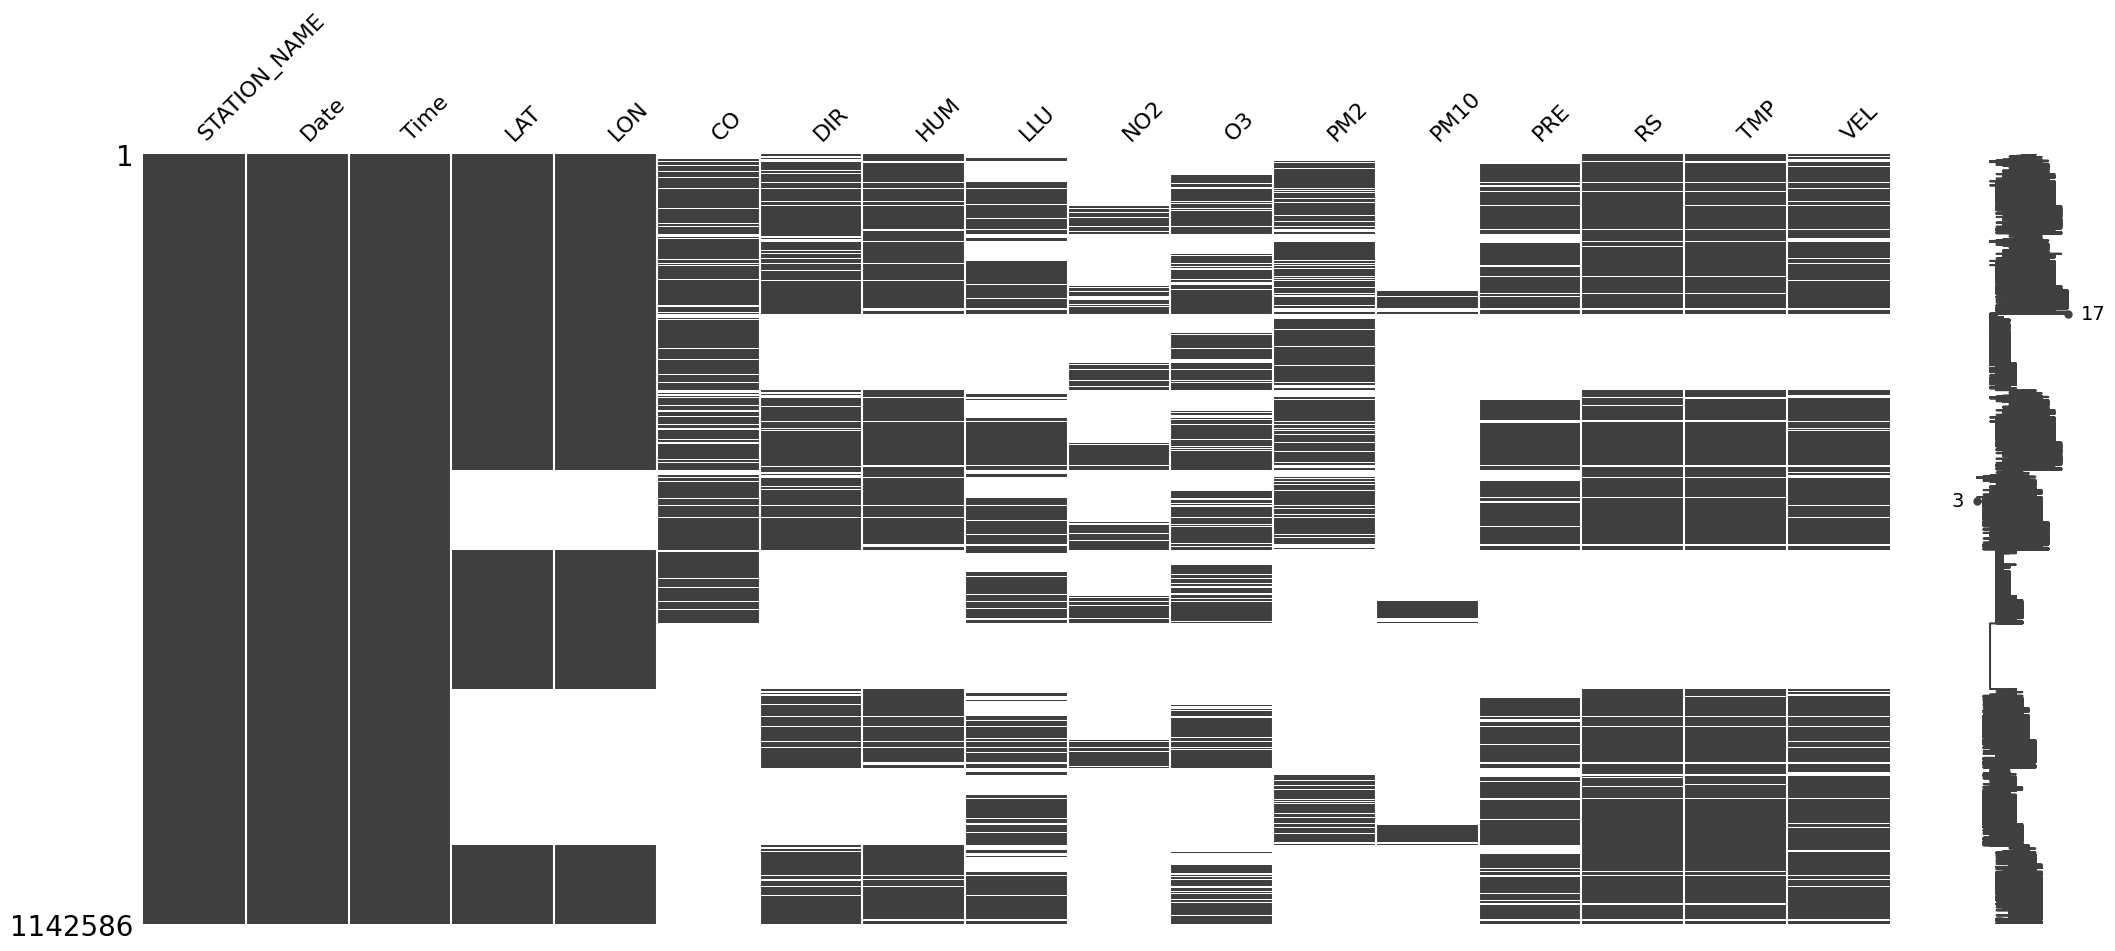

In [16]:
# ------------------------- LIMPIEZA DE DATA -----------------------
# Crear una nueva columna separando fecha y hora
final_df['Date_time'] = pd.to_datetime(final_df['Date_time'], errors='coerce', format='mixed')
final_df['Date'] = final_df['Date_time'].dt.date
final_df['Time'] = final_df['Date_time'].dt.time

# Eliminar columnas innecesarias
final_df.drop(columns=['Date_time'], inplace=True)

# Reordenar columnas
final_df = final_df[[
    "STATION_NAME", "Date", "Time", "LAT", "LON",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2", "PM10", "PRE", "RS", "TMP", "VEL"
]]

# Mostrar el gráfico de Missingno
msno.matrix(final_df)

In [17]:
# Poner fecha, hora y estación como índice
final_df.set_index(['Date', 'Time', 'STATION_NAME'], inplace=True)

# Parametros de imputacion
seq_len = 24

# Selecciona solo las columnas numéricas (excluye STATION_NAME, Date, Time)
n_features = len(final_df.columns)
data_array = final_df.to_numpy(dtype=np.float32)

n_samples = len(data_array) - seq_len + 1
data_windowed = np.array([
    data_array[i:i + seq_len] for i in range(n_samples)
])

# data_windowed.shape será (n_samples, seq_len, n_features)
print("Shape de data_windowed:", data_windowed.shape)

Shape de data_windowed: (1142563, 24, 14)


In [18]:
# Calcular el numero de veces que se repite cada fila
repeat_factor = data_array.shape[0] // data_windowed.shape[0]
extra_rows = data_array.shape[0] % data_windowed.shape[0]

# Repetir las filas para que coincidan con el tamaño original
expanded_array = np.repeat(data_windowed, repeat_factor, axis=0)

# Si hay filas extra, agregarlas al final
if extra_rows > 0:
    expanded_array = np.vstack((expanded_array, data_windowed[:extra_rows]))

expanded_array[-extra_rows:,0,:] = data_array[-extra_rows:]

expanded_array.shape

(1142586, 24, 14)

In [19]:
# data_windowed: (n_samples, seq_len, n_features)
# Filtra ventanas donde al menos el 50% de los datos no son NaN
mask = ~np.isnan(data_windowed).all(axis=(1,2))  # elimina ventanas completamente vacías
data_windowed_filtered = data_windowed[mask]

# Si quieres ser más estricto (ej: al menos 50% de datos no NaN en cada ventana)
min_valid = int(0.5 * seq_len * n_features)
mask = np.sum(~np.isnan(data_windowed), axis=(1,2)) >= min_valid
data_windowed_filtered = data_windowed[mask]

# Normaliza solo sobre los datos no NaN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
flat = data_windowed_filtered.reshape(-1, data_windowed_filtered.shape[-1])
flat_no_nan = flat[~np.isnan(flat).any(axis=1)]
scaler.fit(flat_no_nan)

# Aplica la normalización ignorando los NaN (corrigiendo el error de asignación)
def scale_with_nan(x):
    x_scaled = x.copy()
    row_mask = ~np.isnan(x).any(axis=1)
    if np.any(row_mask):
        x_scaled[row_mask] = scaler.transform(x[row_mask])
    return x_scaled

data_windowed_scaled = np.array([scale_with_nan(win) for win in data_windowed_filtered])

In [20]:
dataset = {"X": data_windowed_scaled}

df = pd.DataFrame(data_windowed_scaled.reshape(-1, n_features), columns=final_df.columns)
df

,LAT,LON,CO,DIR,HUM,LLU,NO2,O3,PM2,PM10,PRE,RS,TMP,VEL
0,-0.184731,-78.495987,NaN,336.540009,98.059998,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.93,0.52
1,-0.184731,-78.495987,NaN,259.170013,98.470001,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.14,0.54
2,-0.184731,-78.495987,NaN,348.760010,98.650002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.71,0.54
3,-0.184731,-78.495987,NaN,300.940002,99.029999,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.63,0.58
4,-0.184731,-78.495987,NaN,248.610001,86.849998,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.18,2.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485771,-0.214956,-78.403214,NaN,63.730000,75.209999,0.0,NaN,27.42,NaN,NaN,770.539978,0.0,16.43,1.39
14485772,-0.214956,-78.403214,NaN,48.689999,76.470001,0.0,NaN,28.90,NaN,NaN,771.429993,0.0,15.80,1.72
14485773,-0.214956,-78.403214,NaN,32.799999,77.910004,0.0,NaN,29.82,NaN,NaN,771.900024,0.0,15.17,1.56
14485774,-0.214956,-78.403214,NaN,67.040001,80.830002,0.0,NaN,22.57,NaN,NaN,772.309998,0.0,14.64,0.85


In [21]:
# Inicializar el imputador SAITS
saits_imputer = SAITS(
    n_steps=seq_len, n_features=n_features,
    n_layers=1,
    d_model=32,
    d_ffn=64,
    n_heads=2,
    d_k=32, d_v=32,
    dropout=0.1,
    epochs=10,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Entrenar el modelo antes de predecir
saits_imputer.fit(dataset)

batch_size = 1000
imputed_batches = []
for i in range(0, data_windowed_scaled.shape[0], batch_size):
    batch = data_windowed_scaled[i:i+batch_size]
    pred = saits_imputer.predict({"X": batch})
    # Extrae el array imputado del dict
    imputed = pred["imputation"] if isinstance(pred, dict) and "imputation" in pred else None
    if isinstance(imputed, np.ndarray) and imputed.ndim == 3:
        imputed_batches.append(imputed)
    else:
        print(f"Warning: batch {i//batch_size} prediction is not a valid array. Got: {type(imputed)}, shape: {getattr(imputed, 'shape', None)}")

if len(imputed_batches) > 0:
    imputed_data = np.concatenate(imputed_batches, axis=0)
else:
    raise ValueError("No valid batches were predicted.")

2025-06-23 18:50:51 [INFO]: Using the given device: cuda
2025-06-23 18:50:51 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-06-23 18:50:51 [INFO]: Using customized MAE as the training loss function.
2025-06-23 18:50:51 [INFO]: Using customized MSE as the validation metric function.
2025-06-23 18:50:51 [WARNING]: ‼️ d_model must = n_heads * d_k, it should be divisible by n_heads and the result should be equal to d_k, but got d_model=32, n_heads=2, d_k=32
2025-06-23 18:50:51 [WARNING]: ⚠️ d_model is reset to 64 = n_heads (2) * d_k (32)


2025-06-23 18:50:51 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 56,208
2025-06-23 19:00:05 [INFO]: Epoch 001 - training loss (MAE): 91.0736
2025-06-23 19:06:43 [INFO]: Epoch 002 - training loss (MAE): 61.7159
2025-06-23 19:12:41 [INFO]: Epoch 003 - training loss (MAE): 55.5077
2025-06-23 19:19:13 [INFO]: Epoch 004 - training loss (MAE): 53.5447
2025-06-23 19:25:46 [INFO]: Epoch 005 - training loss (MAE): 51.0578
2025-06-23 19:33:29 [INFO]: Epoch 006 - training loss (MAE): 50.4222
2025-06-23 19:40:18 [INFO]: Epoch 007 - training loss (MAE): 51.4915
2025-06-23 19:47:08 [INFO]: Epoch 008 - training loss (MAE): 49.9926
2025-06-23 19:53:25 [INFO]: Epoch 009 - training loss (MAE): 49.8903
2025-06-23 19:59:06 [INFO]: Epoch 010 - training loss (MAE): 48.4911
2025-06-23 19:59:06 [INFO]: Finished training. The best model is from epoch#10.


<Figure size 1500x600 with 0 Axes>

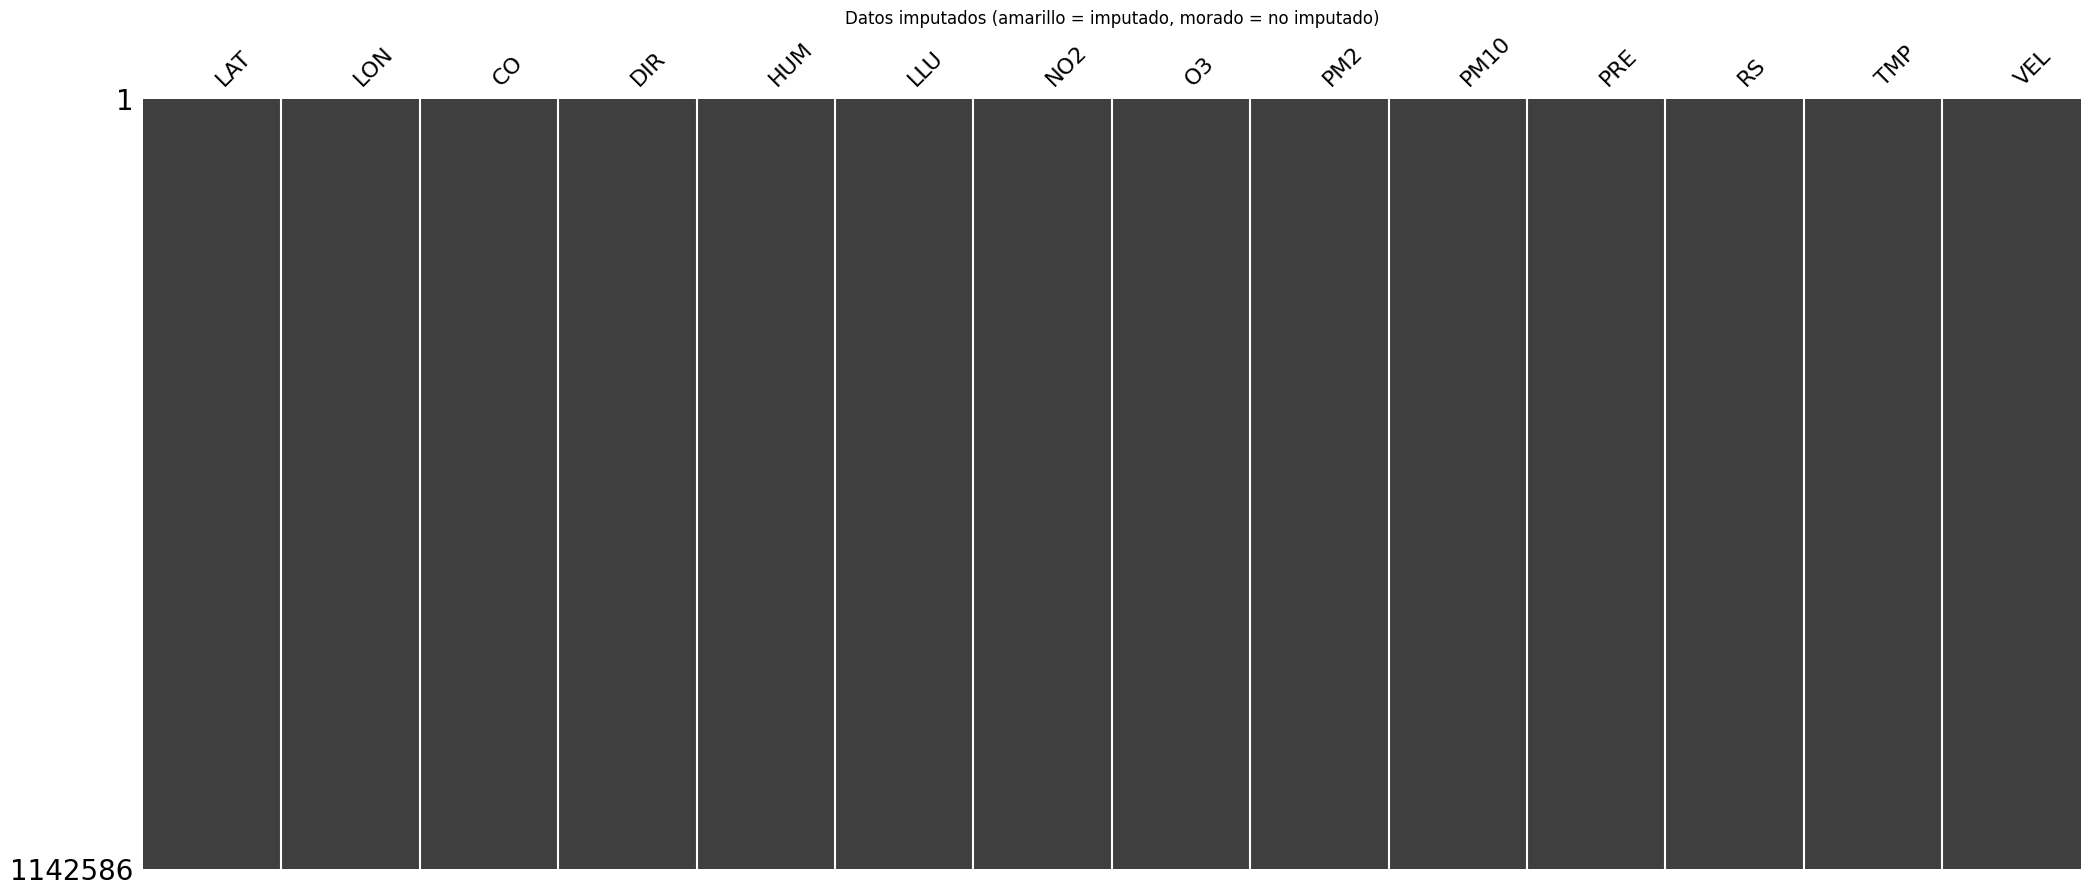

In [22]:
# Paso 1: Asegurar que reshape sea correcto para desnormalizar
imputed_data_reshaped = imputed_data.reshape(-1, imputed_data.shape[-1])

# Paso 2: Desnormalizar los datos
imputed_data_descaled = scaler.inverse_transform(imputed_data_reshaped)

# Paso 3: Restaurar la forma original
imputed_data_descaled = imputed_data_descaled.reshape(imputed_data.shape)

# Paso 4: Reconstruir la serie imputada del mismo tamaño que `final_df`
reconstructed = np.full_like(data_array, np.nan)
count = np.zeros_like(data_array)

for i in range(data_windowed_filtered.shape[0]):
    for t in range(seq_len):
        if i + t < reconstructed.shape[0]:
            nan_mask = np.isnan(data_array[i + t])
            # Acumular solo valores que eran NaN
            reconstructed[i + t, nan_mask] = np.nansum([
                reconstructed[i + t, nan_mask],
                imputed_data_descaled[i, t, nan_mask]
            ], axis=0)
            count[i + t, nan_mask] += 1

# Paso 5: Evitar división por cero y promediar imputaciones
count[count == 0] = 1
reconstructed = reconstructed / count

# Paso 6: Crear DataFrame imputado con índice original
imputed_df = pd.DataFrame(reconstructed, index=final_df.index, columns=final_df.columns)

# Paso 7: Marcar los valores que fueron imputados
mask_imputed = final_df.isna() & imputed_df.notna()

# Paso 8: Visualizar los datos imputados
import missingno as msno
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
msno.matrix(mask_imputed.astype(float), sparkline=False)
plt.title("Datos imputados (amarillo = imputado, morado = no imputado)")
plt.show()

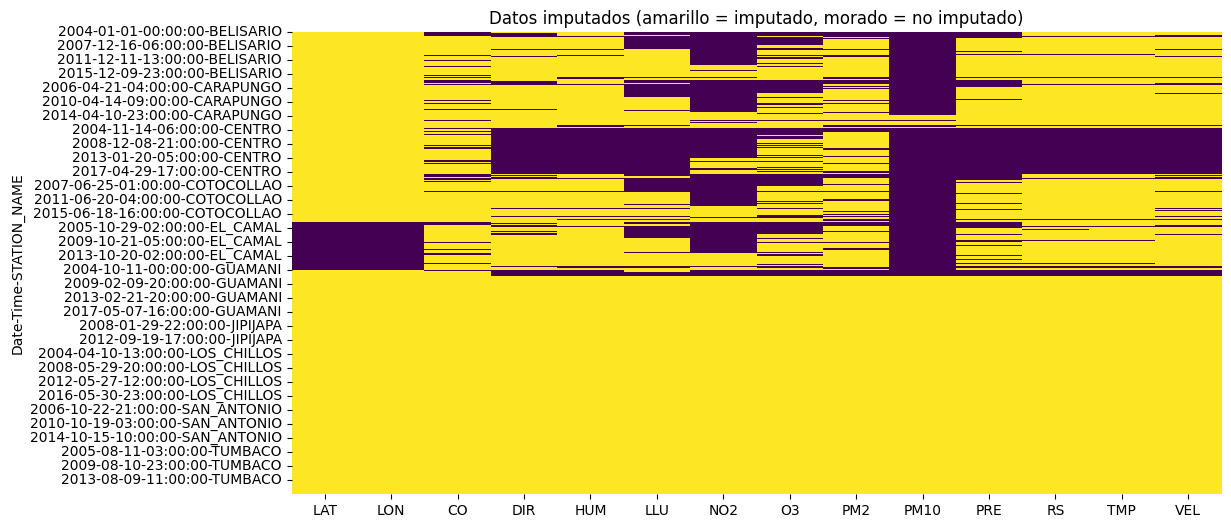

                                  LAT  LON         CO  DIR  HUM       LLU  \
Date       Time     STATION_NAME                                            
2004-01-01 00:00:00 BELISARIO     NaN  NaN  24.095224  NaN  NaN -4.381777   
           01:00:00 BELISARIO     NaN  NaN  25.911484  NaN  NaN -4.520918   
           02:00:00 BELISARIO     NaN  NaN  23.140188  NaN  NaN -4.313509   
           03:00:00 BELISARIO     NaN  NaN  23.722551  NaN  NaN -4.333780   
           04:00:00 BELISARIO     NaN  NaN  25.486258  NaN  NaN -4.964932   

                                           NO2            O3           PM2  \
Date       Time     STATION_NAME                                             
2004-01-01 00:00:00 BELISARIO     26499.324219  16479.980469  12548.663086   
           01:00:00 BELISARIO     27809.789062  14226.099609  13571.492188   
           02:00:00 BELISARIO     26260.541016  16412.076172  12175.110352   
           03:00:00 BELISARIO     26789.736328  15160.551758  12467.49

In [23]:
# Sacar grafico que muestre los datos que se han imputado
plt.figure(figsize=(12, 6))
sns.heatmap(imputed_df.isnull(), cbar=False, cmap='viridis')
plt.title('Datos imputados (amarillo = imputado, morado = no imputado)')
plt.show()

# tabla  de datos imputados
print(imputed_df.head())

## Predicción de PM2 usando RandomForest con la data imputada
En esta sección se entrena un modelo RandomForest para predecir los valores de PM2 a partir del resto de variables ambientales.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Preparamos los datos: eliminamos filas con NaN en PM2 y en las features
target = "PM2"
features = [col for col in imputed_df.columns if col != target]

df_model = imputed_df.dropna(subset=[target] + features)
X = df_model[features]
y = df_model[target]

# 2. Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenamos el modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 4. Predicción y evaluación
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R2 Score: {r2:.3f}")

Mean Squared Error (MSE): 1123249.313
R2 Score: 0.969


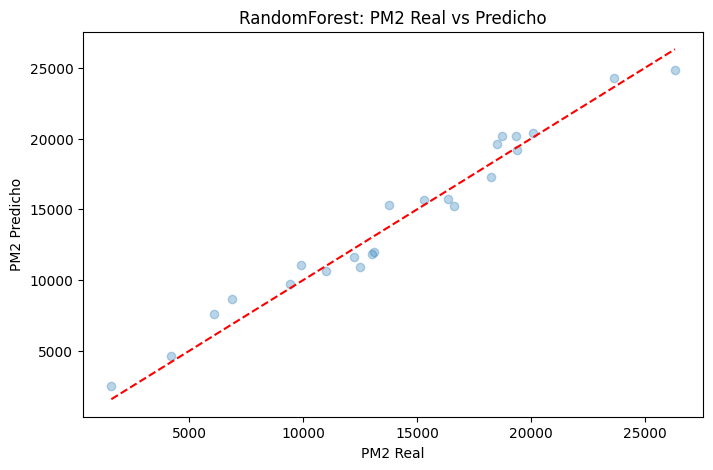

In [36]:
# Visualización de resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("PM2 Real")
plt.ylabel("PM2 Predicho")
plt.title("RandomForest: PM2 Real vs Predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()